In [ ]:
!pip install lime
!pip install mlflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, PowerTransformer, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression, RFE, mutual_info_regression
from xgboost import XGBRegressor
import datetime as dt
import warnings
from statsmodels.stats.outliers_influence import variance_inflation_factor
import shap
import lime
from lime import lime_tabular
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import mlflow
import mlflow.sklearn
import mlflow.pytorch

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Setting visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# Function to set figure size for better readability
def set_figure_size(width=12, height=8):
    plt.figure(figsize=(width, height))

# Function to calculate adjusted R-squared
def adjusted_r2_score(y_true, y_pred, X):
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    p = X.shape[1]  # number of predictors
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    return adjusted_r2

print("### Enhanced Smart Factory Energy Prediction Challenge ###")
print("Let's start by exploring the dataset and building a predictive model.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 700.2/700.2 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.9 MB/s eta 0:00:00
### Enhanced Smart Factory Energy Prediction Challenge ###
Let's start by exploring the dataset and building a predictive model.


In [ ]:
# ## 2. Data Loading and Initial Examination

# Load the data
print("\n1. Loading and Examining the Data...")
df = pd.read_csv('/data.csv')

# Display basic information about the dataset
print(f"\nDataset shape: {df.shape}")
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

# Display the first few rows
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Check for missing values in the raw data
print("\nMissing values per column:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])
missing_percentage = (df.isnull().sum() / len(df)) * 100
print("\nPercentage of missing values per column:")
print(missing_percentage[missing_percentage > 0])



1. Loading and Examining the Data...

Dataset shape: (16857, 29)
Number of rows: 16857
Number of columns: 29

First 5 rows of the dataset:
             timestamp equipment_energy_consumption     lighting_energy  \
0  2016-01-11 17:00:00                         60.0  -77.78778596503064   
1  2016-01-11 17:10:00                         60.0                30.0   
2  2016-01-11 17:20:00                         50.0                30.0   
3  2016-01-11 17:30:00                         50.0                40.0   
4  2016-01-11 17:40:00                         60.0                40.0   

   zone1_temperature     zone1_humidity zone2_temperature  zone2_humidity  \
0  33.74660933896648  47.59666666666671              19.2       44.790000   
1              19.89  46.69333333333329              19.2       44.722500   
2              19.89               46.3              19.2       44.626667   
3  33.74660933896648   46.0666666666667              19.2       44.590000   
4              19.89  46

In [ ]:
# ## 3. Basic Cleaning (can be done on the entire dataset)

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Extract time-based features
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day
df['month'] = df['timestamp'].dt.month
df['year'] = df['timestamp'].dt.year
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
df['is_night'] = df['hour'].apply(lambda x: 1 if x >= 20 or x <= 6 else 0)

# Create additional cyclical time features (to better capture time patterns)
df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
df['day_sin'] = np.sin(2 * np.pi * df['day']/31)
df['day_cos'] = np.cos(2 * np.pi * df['day']/31)
df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week']/7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week']/7)

# Create a clean copy of original data for working
df_clean = df.copy()
# Replace "error" with NaN
df_clean['equipment_energy_consumption'] = pd.to_numeric(df_clean['equipment_energy_consumption'], errors='coerce')

# Now, apply rolling statistics
df_clean['lag_1'] = df_clean['equipment_energy_consumption'].shift(1).bfill()
df_clean['rolling_mean_3'] = df_clean['equipment_energy_consumption'].rolling(3).mean().bfill()
df_clean['rolling_std_3'] = df_clean['equipment_energy_consumption'].rolling(3).std().bfill()
# Identify columns with missing values for imputation
columns_with_na = df_clean.columns[df_clean.isnull().any()].tolist()
print(f"\nColumns with missing values: {columns_with_na}")

# Impute missing values with median for each column
for col in columns_with_na:
    if not pd.api.types.is_numeric_dtype(df_clean[col]):
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())

# Verify all missing values have been addressed
assert df_clean.isnull().sum().sum() == 0, "There are still missing values in the dataset"
print("All missing values have been successfully addressed")



Columns with missing values: ['equipment_energy_consumption', 'lighting_energy', 'zone1_temperature', 'zone1_humidity', 'zone2_temperature', 'zone2_humidity', 'zone3_temperature', 'zone3_humidity', 'zone4_temperature', 'zone4_humidity', 'zone5_temperature', 'zone5_humidity', 'zone6_temperature', 'zone6_humidity', 'zone7_temperature', 'zone7_humidity', 'zone8_temperature', 'zone8_humidity', 'zone9_temperature', 'zone9_humidity', 'outdoor_temperature', 'atmospheric_pressure', 'outdoor_humidity', 'wind_speed', 'visibility_index', 'dew_point', 'random_variable1', 'random_variable2']
All missing values have been successfully addressed



2. Performing Exploratory Data Analysis on Raw Data...


<Figure size 1200x800 with 0 Axes>

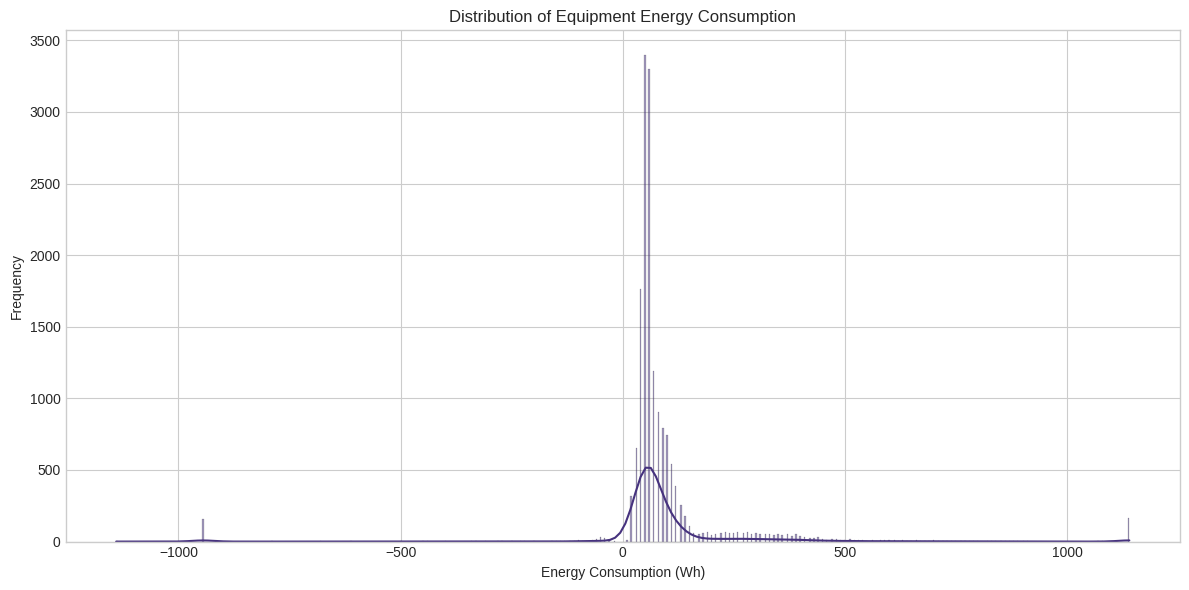

In [ ]:
# ## 4. Exploratory Data Analysis (on Raw Data)

print("\n2. Performing Exploratory Data Analysis on Raw Data...")

# Target variable distribution
set_figure_size()
plt.figure(figsize=(12, 6))
sns.histplot(df_clean['equipment_energy_consumption'], kde=True)
plt.title('Distribution of Equipment Energy Consumption')
plt.xlabel('Energy Consumption (Wh)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [ ]:
# Correlation analysis
numerical_columns = df_clean.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = df_clean[numerical_columns].corr()

# Top correlated features with target variable
target_correlations = correlation_matrix['equipment_energy_consumption'].sort_values(ascending=False)
print("\nTop 10 features correlated with equipment_energy_consumption:")
print(target_correlations[1:11])  # Exclude the target itself

# Check correlation of random variables with target
print("\nAnalyzing random variables correlation with target:")
print(f"random_variable1: {correlation_matrix['equipment_energy_consumption']['random_variable1']:.4f}")
print(f"random_variable2: {correlation_matrix['equipment_energy_consumption']['random_variable2']:.4f}")



Top 10 features correlated with equipment_energy_consumption:
rolling_mean_3         0.650712
lag_1                  0.258118
rolling_std_3          0.129205
lighting_energy        0.053486
zone2_temperature      0.040172
zone3_temperature      0.036205
outdoor_temperature    0.031639
zone6_temperature      0.030792
zone1_humidity         0.025691
day_sin                0.020112
Name: equipment_energy_consumption, dtype: float64

Analyzing random variables correlation with target:
random_variable1: -0.0154
random_variable2: -0.0103


<Figure size 1400x1200 with 0 Axes>

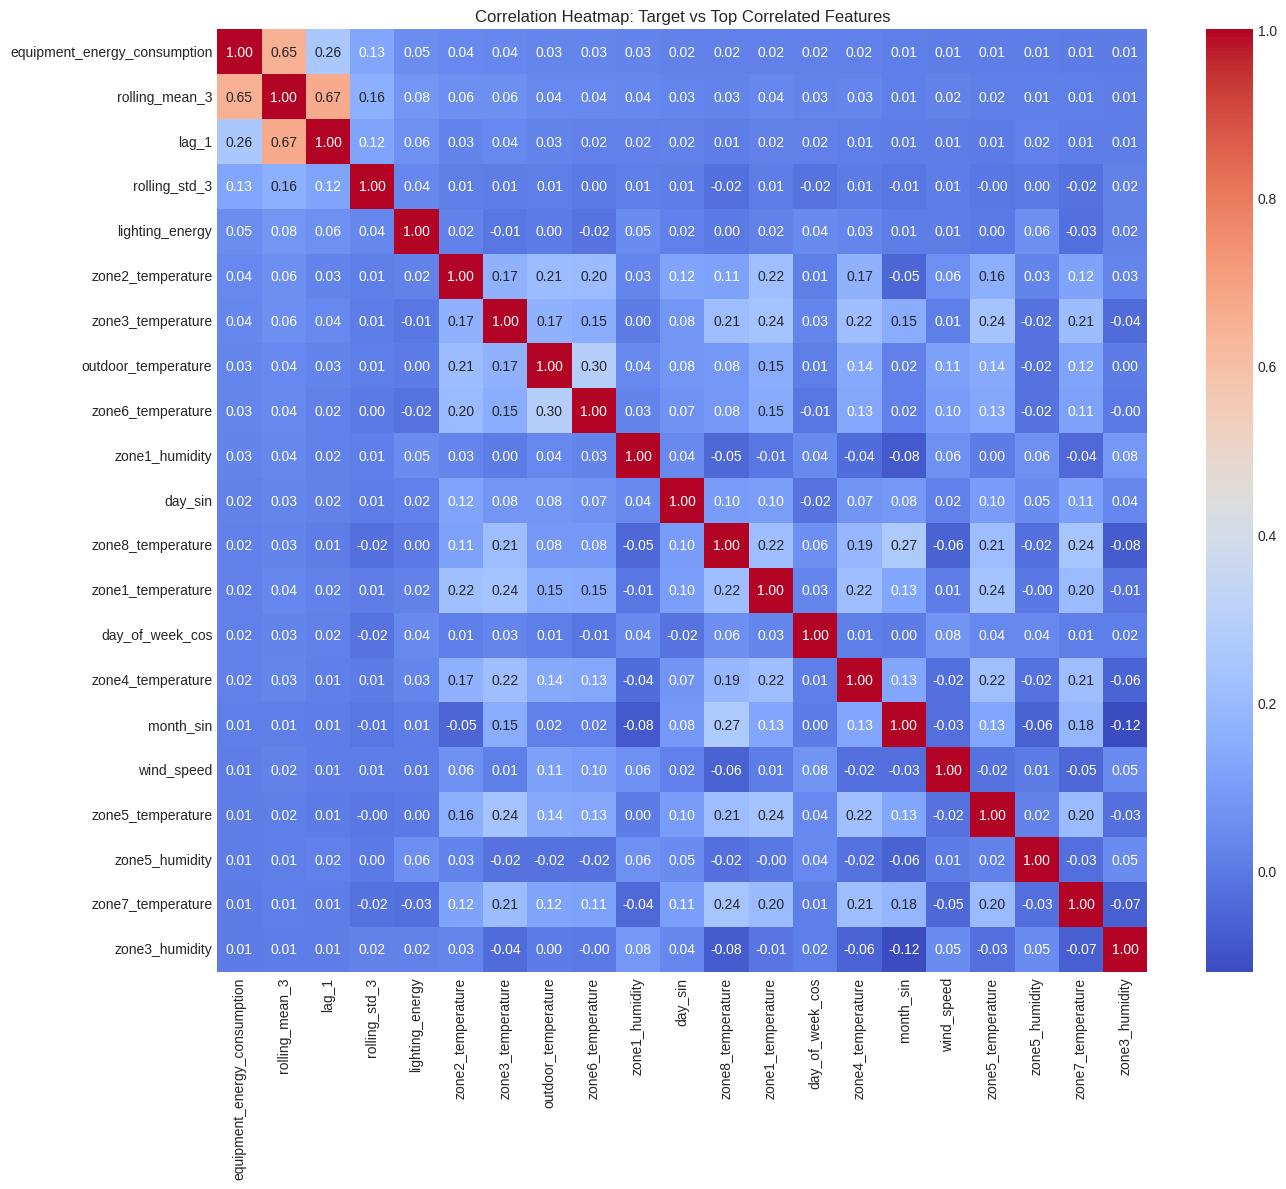

In [ ]:
# Correlation heatmap (focusing on most relevant features)
top_features = target_correlations[0:21].index.tolist()  # Include target and top 20 correlated features
set_figure_size(14, 12)
plt.figure(figsize=(14, 12))
heatmap = sns.heatmap(df_clean[top_features].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap: Target vs Top Correlated Features')
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

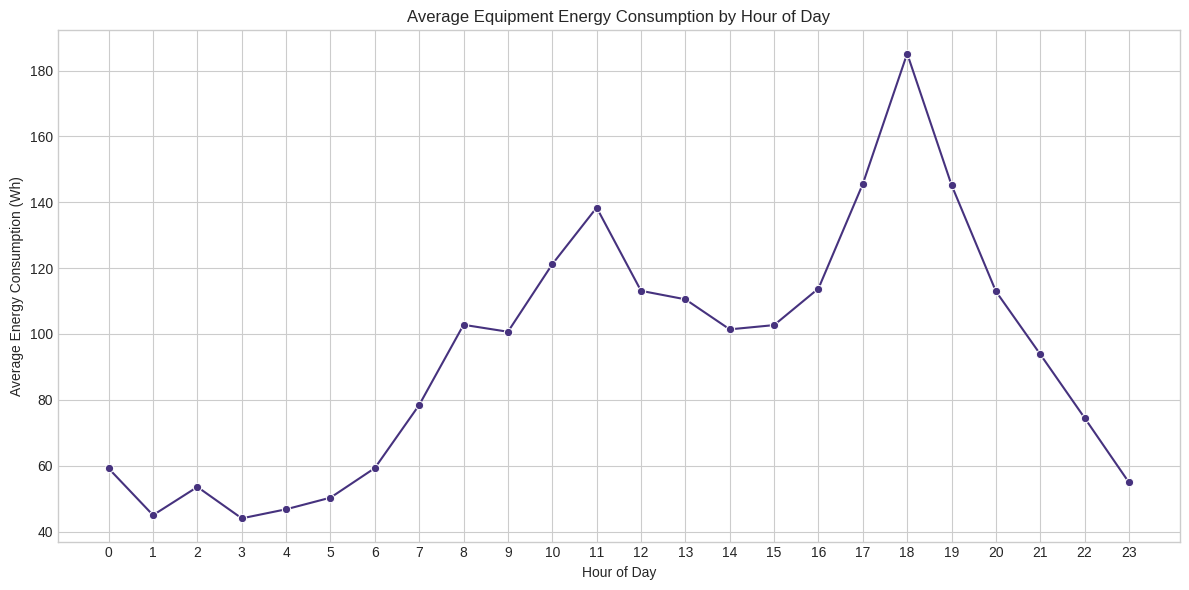

In [ ]:
# Energy consumption by hour of day
hourly_consumption = df_clean.groupby('hour')['equipment_energy_consumption'].mean().reset_index()
set_figure_size(12, 6)
plt.figure(figsize=(12, 6))
sns.lineplot(x='hour', y='equipment_energy_consumption', data=hourly_consumption, marker='o')
plt.title('Average Equipment Energy Consumption by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Energy Consumption (Wh)')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

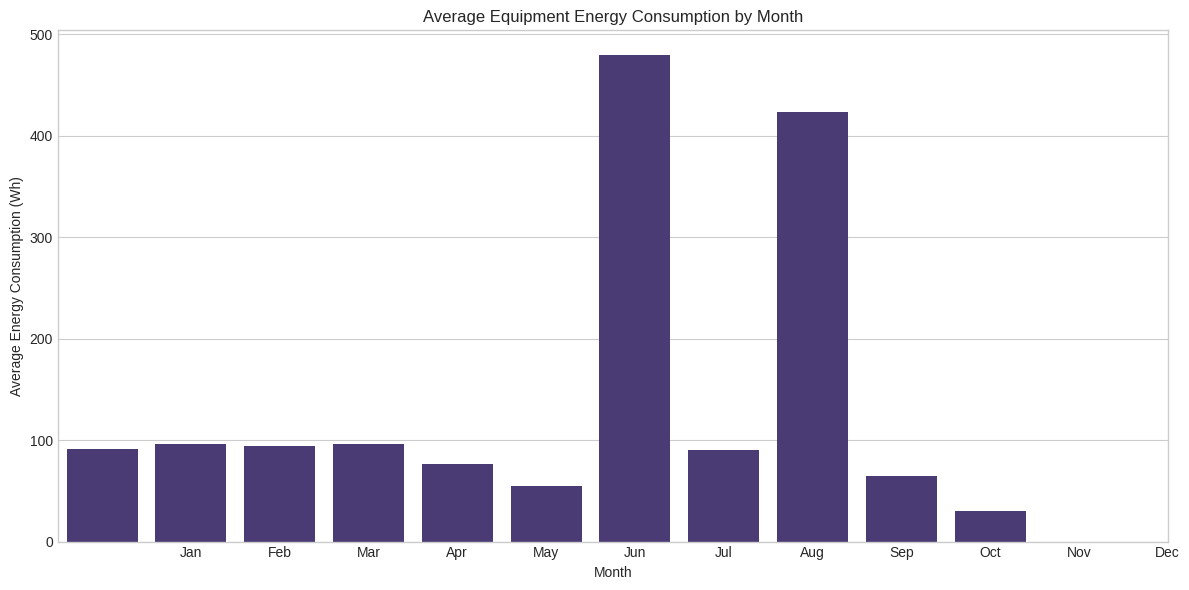

In [ ]:
# Seasonal patterns (monthly)
monthly_consumption = df_clean.groupby('month')['equipment_energy_consumption'].mean().reset_index()
set_figure_size(12, 6)
plt.figure(figsize=(12, 6))
sns.barplot(x='month', y='equipment_energy_consumption', data=monthly_consumption)
plt.title('Average Equipment Energy Consumption by Month')
plt.xlabel('Month')
plt.ylabel('Average Energy Consumption (Wh)')
plt.xticks(range(0, 13), ['', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

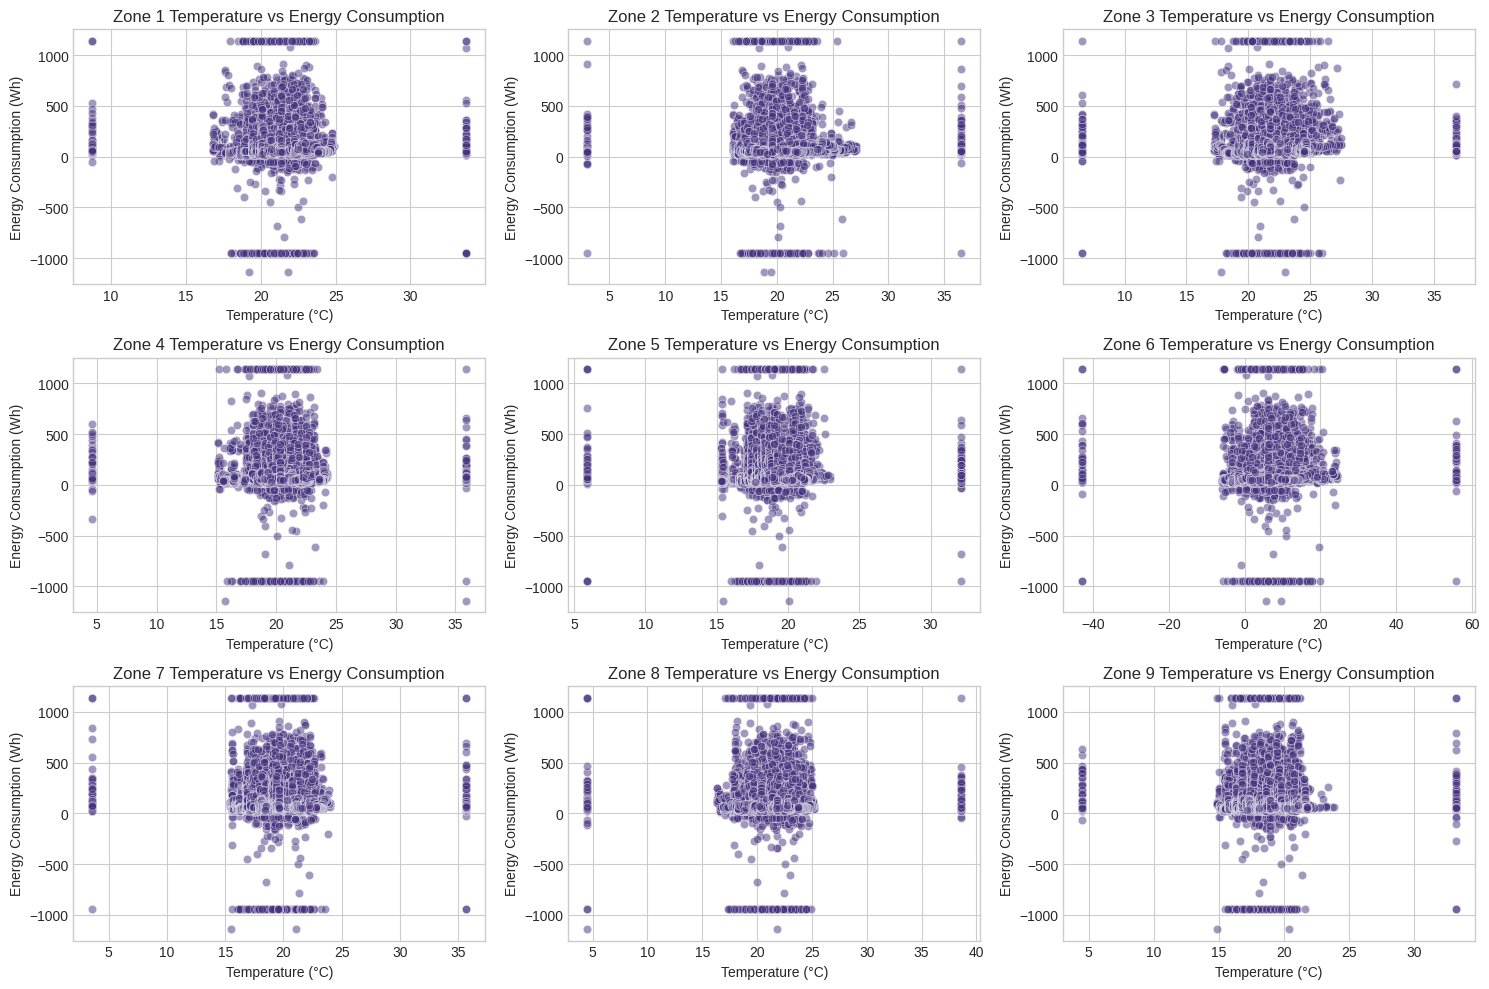

In [ ]:
# Zone temperatures vs energy consumption
plt.figure(figsize=(15, 10))
for i in range(1, 10):
    plt.subplot(3, 3, i)
    zone_temp_col = f'zone{i}_temperature'
    if zone_temp_col in df_clean.columns:
        sns.scatterplot(
            x=zone_temp_col,
            y='equipment_energy_consumption',
            data=df_clean,
            alpha=0.5
        )
        plt.title(f'Zone {i} Temperature vs Energy Consumption')
        plt.xlabel('Temperature (°C)')
        plt.ylabel('Energy Consumption (Wh)')
    else:
        plt.text(0.5, 0.5, f"{zone_temp_col}\nNot Found", ha='center', va='center')
        plt.axis('off')
plt.tight_layout()
plt.show()

<Figure size 1500x1200 with 0 Axes>

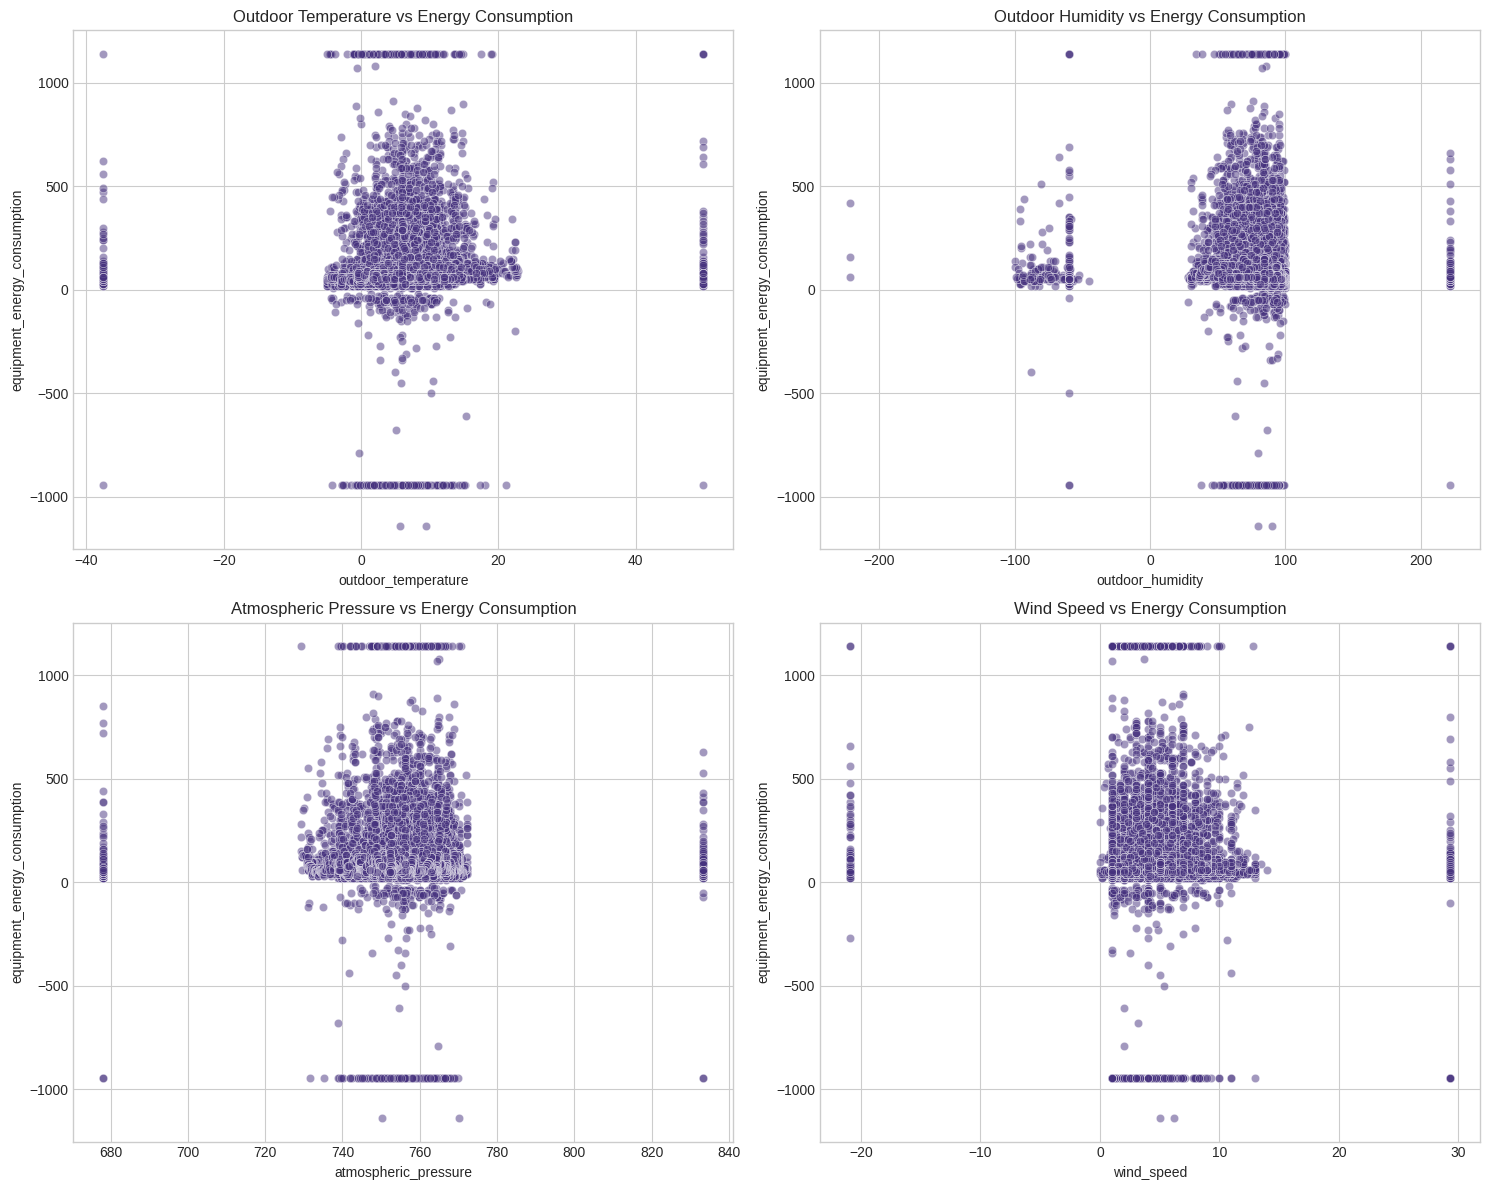

In [ ]:
# Outdoor conditions impact
outdoor_conditions = ['outdoor_temperature', 'outdoor_humidity', 'atmospheric_pressure', 'wind_speed']
set_figure_size(15, 12)
plt.figure(figsize=(15, 12))
for i, condition in enumerate(outdoor_conditions, 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(x=condition, y='equipment_energy_consumption', data=df_clean, alpha=0.5)
    plt.title(f'{condition.replace("_", " ").title()} vs Energy Consumption')
plt.tight_layout()
plt.show()

<Figure size 1600x1400 with 0 Axes>

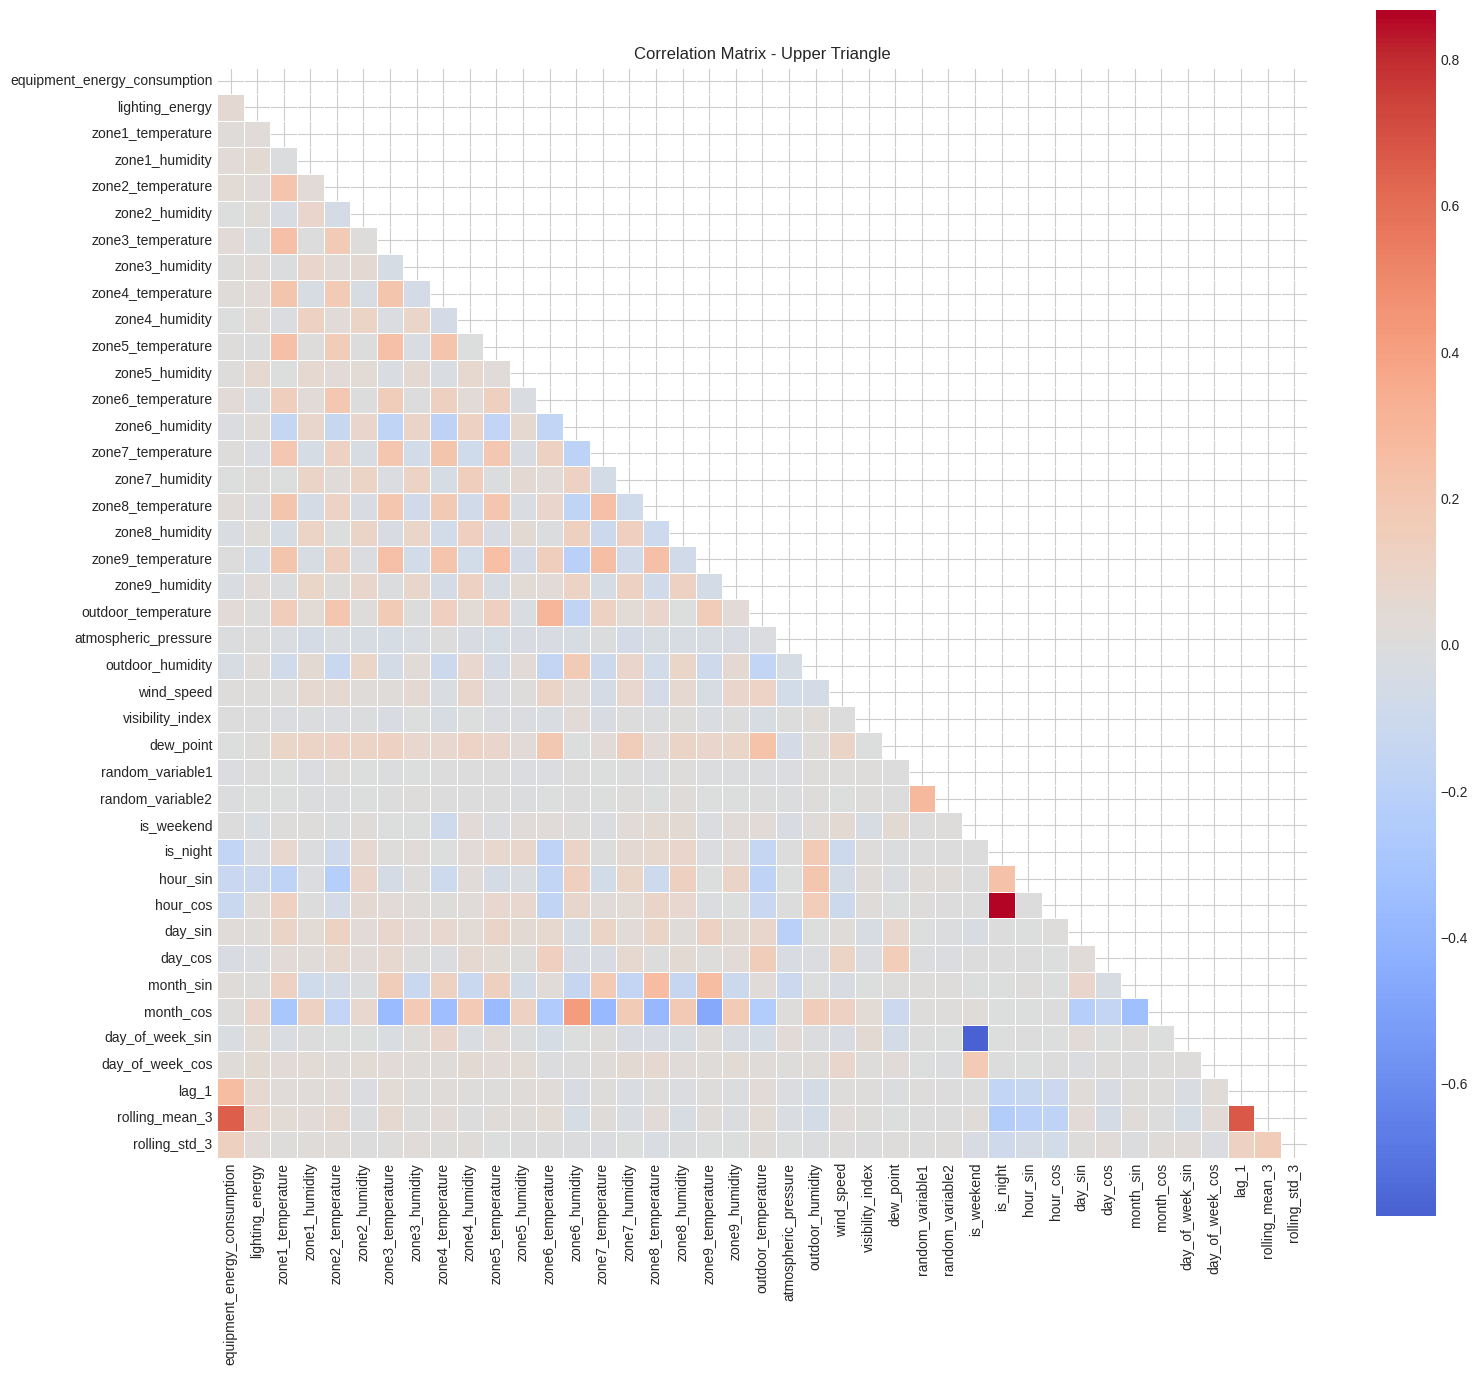

In [ ]:
# Checking for highly correlated features
high_corr_threshold = 0.8
high_corr_features = []

# Create a correlation matrix mask to only show upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
set_figure_size(16, 14)
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', annot=False,
            center=0, linewidths=0.5, square=True)
plt.title('Correlation Matrix - Upper Triangle')
plt.tight_layout()
plt.show()

In [ ]:
# Identify highly correlated feature pairs
print("\nHighly correlated feature pairs (corr > 0.8):")
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > high_corr_threshold:
            print(f"{correlation_matrix.columns[i]} & {correlation_matrix.columns[j]}: {correlation_matrix.iloc[i, j]:.4f}")
            # Add to list of high correlation features if not already there
            if correlation_matrix.columns[i] not in high_corr_features:
                high_corr_features.append(correlation_matrix.columns[i])
            if correlation_matrix.columns[j] not in high_corr_features:
                high_corr_features.append(correlation_matrix.columns[j])

print(f"Number of highly correlated features identified: {len(high_corr_features)}")


Highly correlated feature pairs (corr > 0.8):
is_night & hour_cos: 0.8675
Number of highly correlated features identified: 2



Calculating mutual information with target variable...

Top 10 features by mutual information score:
             Feature  MI_Score
0     rolling_mean_3  0.982815
1              lag_1  0.685982
2      rolling_std_3  0.385568
3           hour_sin  0.149644
4  zone8_temperature  0.098757
5           hour_cos  0.095534
6     zone6_humidity  0.088115
7  zone3_temperature  0.085807
8  zone9_temperature  0.084799
9     zone8_humidity  0.084243


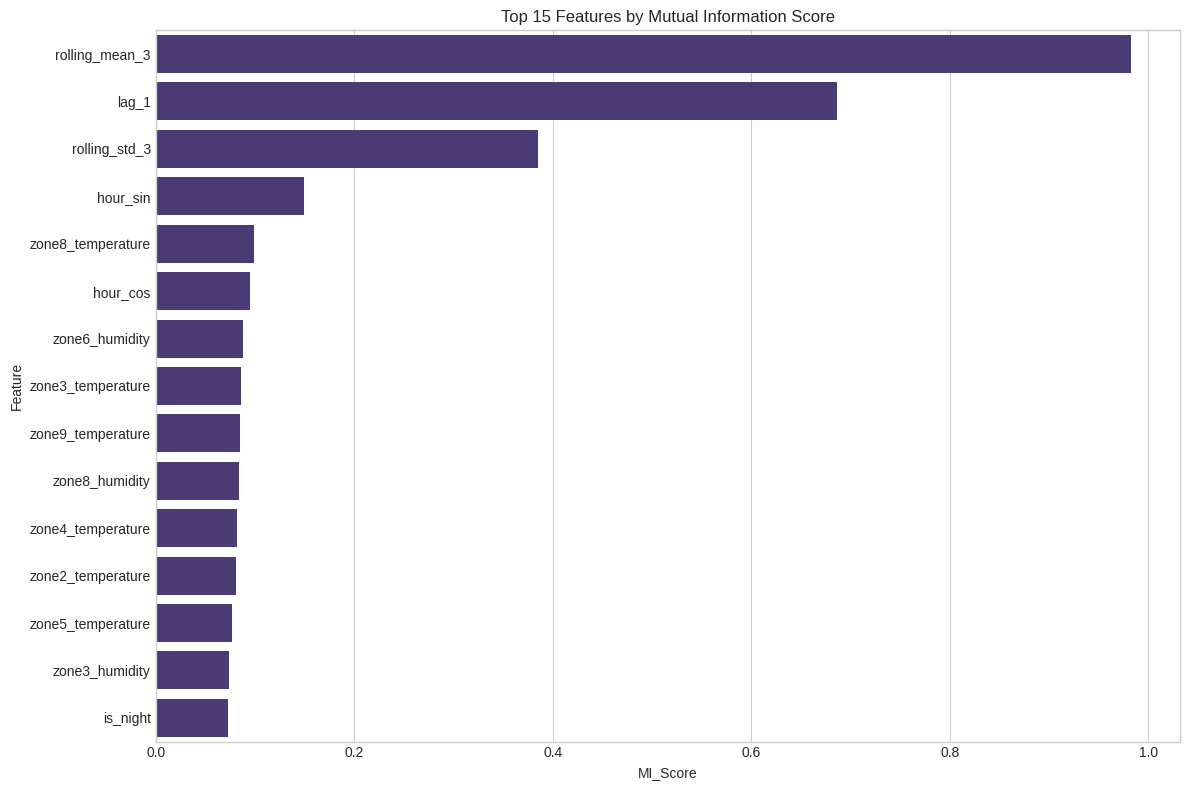

In [ ]:
# Calculate mutual information with target (for non-linear relationships)
print("\nCalculating mutual information with target variable...")
numerical_X = df_clean.drop(['timestamp', 'equipment_energy_consumption'], axis=1)
numerical_X = numerical_X.select_dtypes(include=['float64', 'int64'])
y_for_mi = df_clean['equipment_energy_consumption']

mi_scores = mutual_info_regression(numerical_X, y_for_mi, random_state=42)
mi_df = pd.DataFrame({'Feature': numerical_X.columns, 'MI_Score': mi_scores})
mi_df = mi_df.sort_values('MI_Score', ascending=False).reset_index(drop=True)

print("\nTop 10 features by mutual information score:")
print(mi_df.head(10))

# Visualize mutual information scores
plt.figure(figsize=(12, 8))
sns.barplot(x='MI_Score', y='Feature', data=mi_df.head(15))
plt.title('Top 15 Features by Mutual Information Score')
plt.tight_layout()
plt.show()

In [ ]:
# ## 5. Data Preparation and Feature Engineering

print("\n3. Data Preparation and Feature Engineering...")

# Create a subset of features
# First, define target variable
target = 'equipment_energy_consumption'
y = df_clean[target]

# Don't exclude lag/rolling features!
exclude_cols = ['timestamp', target, 'random_variable1', 'random_variable2']
features = [col for col in df_clean.columns if col not in exclude_cols]
X = df_clean[features]

# First, split the data to avoid data leakage
# As per recommendation: 70% train, 10% validation, 20% test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)


print(f"Training set size: {X_train.shape[0]} ({X_train.shape[0]/X.shape[0]:.1%})")
print(f"Validation set size: {X_val.shape[0]} ({X_val.shape[0]/X.shape[0]:.1%})")
print(f"Test set size: {X_test.shape[0]} ({X_test.shape[0]/X.shape[0]:.1%})")



3. Data Preparation and Feature Engineering...
Training set size: 11799 (70.0%)
Validation set size: 1686 (10.0%)
Test set size: 3372 (20.0%)


In [ ]:
# Feature scaling and transformation setup
print("\n4. Setting up preprocessing pipelines...")

# Define numerical features for transformation
numerical_features = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Create preprocessing pipelines
# Note: We'll fit on training data only and then transform test data
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('power', PowerTransformer(method='yeo-johnson'))
])

# Apply transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features)
    ])

# Fit the preprocessor on training data only
preprocessor.fit(X_train)

# Transform the datasets
X_train_transformed = preprocessor.transform(X_train)
X_val_transformed = preprocessor.transform(X_val)
X_test_transformed = preprocessor.transform(X_test)

# Convert back to DataFrames for easier handling
X_train_processed = pd.DataFrame(X_train_transformed, columns=numerical_features)
X_val_processed = pd.DataFrame(X_val_transformed, columns=numerical_features)
X_test_processed = pd.DataFrame(X_test_transformed, columns=numerical_features)



4. Setting up preprocessing pipelines...


In [ ]:
# Enhanced Feature Engineering
print("\n5. Enhanced Feature Engineering...")

# Function to create targeted interaction terms that may have physical meaning
def create_targeted_interactions(X):
    interactions = pd.DataFrame(index=X.index)

    # Create temperature-humidity interactions within same zones
    for zone in range(1, 10):
        temp_col = f'zone{zone}_temperature'
        humid_col = f'zone{zone}_humidity'
        if temp_col in X.columns and humid_col in X.columns:
            interactions[f'{temp_col}_x_{humid_col}'] = X[temp_col] * X[humid_col]
            # Heat index approximation (temperature feeling based on humidity)
            interactions[f'heat_index_z{zone}'] = X[temp_col] + (0.1 * X[humid_col])

    # Indoor-outdoor temperature differences (thermal gradients)
    for i in range(1, 10):
        temp_col = f'zone{i}_temperature'
        if temp_col in X.columns and 'outdoor_temperature' in X.columns:
            interactions[f'temp_diff_z{i}_out'] = X[temp_col] - X['outdoor_temperature']
            # Squared differences (non-linear effect of large temperature differences)
            interactions[f'temp_diff_z{i}_out_squared'] = (X[temp_col] - X['outdoor_temperature'])**2

    # Zone temperature differences (important for energy transfer)
    for i in range(1, 9):
        for j in range(i+1, 10):
            temp_col_i = f'zone{i}_temperature'
            temp_col_j = f'zone{j}_temperature'
            if temp_col_i in X.columns and temp_col_j in X.columns:
                interactions[f'temp_diff_z{i}_z{j}'] = X[temp_col_i] - X[temp_col_j]
                # Absolute difference (magnitude matters for energy transfer)
                interactions[f'abs_temp_diff_z{i}_z{j}'] = abs(X[temp_col_i] - X[temp_col_j])

    # Weather-related interactions
    if 'outdoor_temperature' in X.columns and 'outdoor_humidity' in X.columns:
        interactions['outdoor_heat_index'] = X['outdoor_temperature'] + (0.1 * X['outdoor_humidity'])

    if 'wind_speed' in X.columns and 'outdoor_temperature' in X.columns:
        # Wind chill effect (temperature feeling considering wind)
        interactions['wind_chill'] = X['outdoor_temperature'] - (0.5 * X['wind_speed'])

    # Time-based feature interactions
    if 'hour' in X.columns:
        # Temperature variations based on time of day
        for zone in range(1, 10):
            temp_col = f'zone{zone}_temperature'
            if temp_col in X.columns:
                interactions[f'hour_x_{temp_col}'] = X['hour'] * X[temp_col]

        # Business hours operations
        interactions['is_business_hours'] = ((X['hour'] >= 8) & (X['hour'] <= 18)).astype(int)

        # Interaction of business hours with temperature
        if 'outdoor_temperature' in X.columns:
            interactions['business_hours_x_outdoor_temp'] = interactions['is_business_hours'] * X['outdoor_temperature']

    return pd.concat([X, interactions], axis=1)

# Apply targeted interactions to processed data
X_train_enhanced = create_targeted_interactions(X_train_processed)
X_val_enhanced = create_targeted_interactions(X_val_processed)
X_test_enhanced = create_targeted_interactions(X_test_processed)

print(f"Original feature count: {X_train_processed.shape[1]}")
print(f"After targeted interactions: {X_train_enhanced.shape[1]}")


5. Enhanced Feature Engineering...
Original feature count: 38
After targeted interactions: 148


In [ ]:
# Create polynomial features - try higher degree for better capturing non-linear patterns
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
poly.fit(X_train_enhanced)

# Transform all datasets
X_train_poly = poly.transform(X_train_enhanced)
X_val_poly = poly.transform(X_val_enhanced)
X_test_poly = poly.transform(X_test_enhanced)

# Get the feature names after polynomial transformation
poly_feature_names = poly.get_feature_names_out(X_train_enhanced.columns)

# Create DataFrames
X_train_poly_df = pd.DataFrame(X_train_poly, columns=poly_feature_names)
X_val_poly_df = pd.DataFrame(X_val_poly, columns=poly_feature_names)
X_test_poly_df = pd.DataFrame(X_test_poly, columns=poly_feature_names)

print(f"After polynomial transformation (degree 3, interaction only): {X_train_poly_df.shape[1]}")




After polynomial transformation (degree 3, interaction only): 11026


In [ ]:
# Identify numeric features
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()

# Define preprocessing pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Final preprocessor
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features)
])


In [ ]:
from sklearn.linear_model import LinearRegression

lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

lr_pipeline.fit(X_train, y_train)
y_pred = lr_pipeline.predict(X_val)


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(name, y_true, y_pred, X_val):
    print(f"\n{name} Evaluation:")
    print("R2 Score:", r2_score(y_true, y_pred))
    print("Adjusted R2 Score:", adjusted_r2_score(y_true, y_pred, X_val))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("MAE:", mean_absolute_error(y_true, y_pred))

evaluate_model("Linear Regression", y_val, y_pred, X_val)



Linear Regression Evaluation:
R2 Score: 0.44104776992203887
Adjusted R2 Score: 0.4264101658456977
RMSE: 115.50560732388783
MAE: 45.69578494940863


In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42)
}

for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
    evaluate_model(name, y_val, y_pred, X_val)



Random Forest Evaluation:
R2 Score: 0.23652250283567455
Adjusted R2 Score: 0.2165288777576806
RMSE: 134.99380598424378
MAE: 47.230031966649214

Gradient Boosting Evaluation:
R2 Score: 0.368075063530497
Adjusted R2 Score: 0.3515264811503578
RMSE: 122.81416732425218
MAE: 45.558311351562686

XGBoost Evaluation:
R2 Score: 0.061628405086834426
Adjusted R2 Score: 0.03705472750993677
RMSE: 149.6591064194332
MAE: 52.11390575659663


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth': [None, 10]
}

grid = GridSearchCV(Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
]), param_grid, cv=3, scoring='neg_mean_squared_error')

grid.fit(X_train, y_train)
print("Best Parameters:", grid.best_params_)


Best Parameters: {'regressor__max_depth': 10, 'regressor__n_estimators': 100}


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__max_depth': [3, 5],
}


In [ ]:
from sklearn.pipeline import Pipeline

gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # You already defined this earlier
    ('regressor', GradientBoostingRegressor(random_state=42))
])

grid_search = GridSearchCV(
    gb_pipeline,
    param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['lighting_energy',
                                                                          'zone1_temperature',
                                                                          'zone1_humidity',
                                                                          'zone2_temperature',
                                                                          'zone2_humidity',
                                                                          'zone3_temperature',
                                                                          'zone3_humidity',
                                                                          'zone4_temperature',
                                                                          'zone4_humidity',
                                                                          'zone5_temperature',
                                                                          'zone5_humidity',
                                                                          '...
                                                                          'atmospheric_pressure',
                                                                          'outdoor_humidity',
                                                                          'wind_speed',
                                                                          'visibility_index',
                                                                          'dew_point',
                                                                          'hour',
                                                                          'day',
                                                                          'month',
                                                                          'year',
                                                                          'day_of_week', ...])])),
                                       ('regressor',
                                        GradientBoostingRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__learning_rate': [0.05, 0.1],
                         'regressor__max_depth': [3, 5],
                         'regressor__n_estimators': [100, 200]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [ ]:
best_model = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)

y_pred_val = best_model.predict(X_val)
evaluate_model("Tuned Gradient Boosting", y_val, y_pred_val, X_val)


Best Parameters: {'regressor__learning_rate': 0.05, 'regressor__max_depth': 3, 'regressor__n_estimators': 100}

Tuned Gradient Boosting Evaluation:
R2 Score: 0.392092501851529
Adjusted R2 Score: 0.37617287796578947
RMSE: 120.45767361283491
MAE: 45.41385142525502


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Helper for Adjusted R²
def adjusted_r2_score(y_true, y_pred, X_val):
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    p = X_val.shape[1]
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Predictions
y_pred_val = best_model.predict(X_val)

# Metrics
r2 = r2_score(y_val, y_pred_val)
adj_r2 = adjusted_r2_score(y_val, y_pred_val, X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
mae = mean_absolute_error(y_val, y_pred_val)

# Print nicely
print("Tuned Gradient Boosting Evaluation:")
print(f"R2 Score: {r2:.4f}")
print(f"Adjusted R2 Score: {adj_r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")


Tuned Gradient Boosting Evaluation:
R2 Score: 0.3921
Adjusted R2 Score: 0.3762
RMSE: 120.4577
MAE: 45.4139
